In [6]:
B = 6
image_path = "compression-lab-imgs\\lena.png"
encode_output_path = "compression-lab-imgs\\lena_B6.neural"
compressor_state_path = "compression-lab-imgs\\lena_B6_state.json"
decode_output_path = "compression-lab-imgs\\lena_decoder_output.bmp"
model_name = "default"

In [ ]:
!python encode.py -i {image_path} -B {B} -s {compressor_state_path} -o {encode_output_path} -m {model_name}

In [7]:
!python decode.py -i {encode_output_path} -B {B} -s {compressor_state_path} -o {decode_output_path}  -m {model_name}

In [2]:
from typing import List

import torch
import numpy as np
from PIL import Image

from trained_models import get_decoder
from looseless_compressors import Huffman


def denormalize(img: torch.Tensor, means: List[int], stds: List[int]):
    result = torch.zeros_like(img)
    for i, (chan, mean, std) in enumerate(zip(img, means, stds)):
        result[i] = chan * std + mean
    return result

def denormalize_imagenet(img: torch.Tensor):
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    return denormalize(img, imagenet_mean, imagenet_std)


def decode_binary_file(filename):
    with open(filename, 'rb') as f:
        binary_data = f.read()
    str_with_padding = ''.join(
        format(byte, '08b') for byte in binary_data)
    pad_end = str_with_padding.rfind('1')
    return str_with_padding[:pad_end]

decoder_output_filename = "compression-lab-imgs\\lena_B6_decoder_out.bmp"

decoder = get_decoder(model_name, B)
decoder.eval()
h = Huffman()
h.init_from_file(compressor_state_path)

compressed_img = decode_binary_file(compressed_img_path)

decoded_tensor_flat = torch.tensor(h.decode(compressed_img))
height = width =int((len(decoded_tensor_flat)/decoder.in_channels)**0.5)
decoded_tensor = decoded_tensor_flat.reshape(1, decoder.in_channels, height, width)
normalized_tensor = (decoded_tensor - 0.5) / 2**B
decoded_img_imagenet_norm = decoder(normalized_tensor.type(torch.float32))
np_decoded_img = denormalize_imagenet(decoded_img_imagenet_norm.squeeze(0)).cpu().detach().numpy().transpose(1,2,0)
np_decoded_img = np.clip(np_decoded_img, 0, 1)
np_decoded_img = (np_decoded_img*255).astype(np.uint8)
pil_img = Image.fromarray(np_decoded_img, 'RGB')
pil_img.save(decoder_output_filename, "BMP")

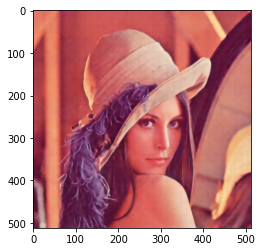

In [3]:
import matplotlib.pyplot as plt
plt.imshow(pil_img)

In [49]:
import PIL

img = PIL.Image.open(args.image_path)
destination = f"{args.image_path}.jpg"
try:
    img.save(destination, "JPEG", quality=50, optimize=True, progressive=True)
except IOError:
    PIL.ImageFile.MAXBLOCK = img.size[0] * img.size[1]
    img.save(destination, "JPEG", quality=50, optimize=True, progressive=True)

In [50]:
import os
jpg_bytes = os.path.getsize(destination)*8

In [51]:
my_bytes/img_size, jpg_bytes/img_size

NameError: name 'my_bytes' is not defined

In [15]:
os.path.getsize('ENCODED')*8

192992

In [16]:
my_bytes

192990

In [18]:
decode_binary_file('ENCODED')[::-1]

'110101010111010101101010101011010101010101010101010101010101110101111010101010101011010101011010101010101010101010110101011101010101011010101010101010110110101101011101110101010101011011010101010111010101010101010101100010101110110110101101010101011011101010101101000101010101010111101010101101010111011010101101010101010101011011010110111010111011011011010111010110110110111011010111010111010101010101010101010101111011011011101101011111010101010111011101010110101101011110111111111011101111011110110101010101010111101111110101010110110101010111110101110111011110101010101010111010101010101010110111011111011010110101010111010110111110111101011011011111010101010101010101111110100101010101010101111011010101110101011011111011101010101010101011101101011101011111010101101011111110101101011101110101011110101101111111110101010111010101010101010101010110101110101011011010001010101010101010101010101010101010101101101101010101000001011010101101011010101010101010101010101010101010101010101110101010101

In [19]:
encoded_img[::-1]

'110101010111010101101010101011010101010101010101010101010101110101111010101010101011010101011010101010101010101010110101011101010101011010101010101010110110101101011101110101010101011011010101010111010101010101010101100010101110110110101101010101011011101010101101000101010101010111101010101101010111011010101101010101010101011011010110111010111011011011010111010110110110111011010111010111010101010101010101010101111011011011101101011111010101010111011101010110101101011110111111111011101111011110110101010101010111101111110101010110110101010111110101110111011110101010101010111010101010101010110111011111011010110101010111010110111110111101011011011111010101010101010101111110100101010101010101111011010101110101011011111011101010101010101011101101011101011111010101101011111110101101011101110101011110101101111111110101010111010101010101010101010110101110101011011010001010101010101010101010101010101010101101101101010101000001011010101101011010101010101010101010101010101010101010101110101010101

In [20]:
encoded_img == decode_binary_file('ENCODED')

True

In [21]:
decoded =h.decode(decode_binary_file('ENCODED'))

In [23]:
torch.all(out == decoded_tensor).item()

True

In [24]:
h

huffman:{4: '00', 3: '01', 2: '1'}

In [25]:
h.encoding = h.get_encoding_from_tree(h.root)

In [26]:
encoded_2 = h.encode(map(int, out.flatten()))

In [27]:
encoded_img == encoded_2

True

In [28]:
h.save_state_to_file("lena.json")

поставить 1 с конца, чтобы однозначно декодировать: убираем все биты с конца до первой единицы с конца включительно